# CIFAKE-10

In [1]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import imageio
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CIFAKE is based on the CIFAR dataset.

## Globals for training

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_size = 32
batch_size = 128

ckpts_path = 'ckpts2'

## Load the data

In [3]:
reals_path = r"C:\Datasets\CIFAKE\train\REAL"
fakes_path = r"C:\Datasets\CIFAKE\train\FAKE"

real_image_paths = [os.path.join(reals_path, img) for img in os.listdir(reals_path)]
fake_image_paths = [os.path.join(fakes_path, img) for img in os.listdir(fakes_path)]

print(len(real_image_paths), len(fake_image_paths))

50000 50000


In [4]:
reals, fakes = [], []

for real in tqdm(real_image_paths):
    real_image = imageio.imread(real)
    reals.append((real_image, 0))

for fake in tqdm(fake_image_paths):
    fake_image = imageio.imread(fake)
    fakes.append((fake_image, 1))

  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\CL-11\AppData\Local\Temp\ipykernel_24196\2340316690.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  real_image = imageio.imread(real)
  0%|          | 0/50000 [00:00<?, ?it/s]C:\Users\CL-11\AppData\Local\Temp\ipykernel_24196\2340316690.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  fake_image = imageio.imread(fake)
100%|██████████| 50000/50000 [02:13<00:00, 375.55it/s]


### Data Exploration

### Preprocessing

In [5]:
# Combine real and fake images
data = reals + fakes

# Separate images and labels
images, labels = zip(*data)

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Assuming images are in NumPy array format and labels are either 0 or 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for pretrained models
])

# Load your data here
images = train_images
labels = train_labels
dataset = ImageDataset(images, labels, transform=transform)

## Training functions

In [6]:
class Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super(Encoder, self).__init__()
        # Initialize the ResNet model
        base_model = models.resnet50(pretrained=pretrained)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Removing the fully connected layer

        # Dummy forward pass to determine input feature size of the last layer
        with torch.no_grad():
            self.dummy_input = torch.zeros(1, 3, 224, 224)  # Assuming the input size is 224x224 for CIFAR-10
            dummy_features = self.features(self.dummy_input)
            self.in_features = dummy_features.numel()

        # Replace the final fully connected layer
        self.projection_head = nn.Linear(self.in_features, 128)  # Projection to 128 dimensions

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.projection_head(x)
        return x
    
def create_classifier(encoder, num_classes, hidden_units, dropout_rate):
    class Classifier(nn.Module):
        def __init__(self, input_dim=128, num_classes=2, hidden_units=512, dropout_rate=0.5):
            super(Classifier, self).__init__()
            self.dropout = nn.Dropout(dropout_rate)
            self.fc1 = nn.Linear(input_dim, hidden_units)  # First fully connected layer
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_units, num_classes)  # Output layer

        def forward(self, x):
            x = self.dropout(x)  # Apply dropout
            x = self.fc1(x)  # Process the flat features
            x = self.relu(x)  # Activation
            x = self.dropout(x)  # Apply dropout again
            x = self.fc2(x)  # Final layer to output class probabilities or scores
            return x  # Returning logits is typical for training with CrossEntropyLoss

    # Instantiate the classifier with the expected dimensions
    classifier = Classifier().to(device)

    return Classifier()
    
class ProjectionHead(nn.Module):
    def __init__(self, encoder, projection_units):
        super(ProjectionHead, self).__init__()
        self.encoder = encoder
        self.fc = nn.Linear(encoder.resnet.fc.in_features, projection_units)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.relu(x)
        return x
    
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.05):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        logits = torch.matmul(feature_vectors_normalized, feature_vectors_normalized.T) / self.temperature
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float()
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(logits.shape[0]).view(-1, 1).to(labels.device),
            0
        )
        logits = logits * logits_mask
        logits = logits - torch.max(logits, 1, keepdim=True).values
        exp_logits = torch.exp(logits)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        loss = -mean_log_prob_pos.mean()
        return loss


def create_classifier(encoder, num_classes, hidden_units, dropout_rate):
    class Classifier(nn.Module):
        def __init__(self, input_dim=128, num_classes=2, hidden_units=512, dropout_rate=0.5):
            super(Classifier, self).__init__()
            self.dropout = nn.Dropout(dropout_rate)
            self.fc1 = nn.Linear(input_dim, hidden_units)  # First fully connected layer
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_units, num_classes)  # Output layer

        def forward(self, x):
            x = self.dropout(x)  # Apply dropout
            x = self.fc1(x)  # Process the flat features
            x = self.relu(x)  # Activation
            x = self.dropout(x)  # Apply dropout again
            x = self.fc2(x)  # Final layer to output class probabilities or scores
            return x  # Returning logits is typical for training with CrossEntropyLoss

    # Instantiate the classifier with the expected dimensions
    classifier = Classifier().to(device)

    return Classifier()

def train_encoder(encoder, train_dataloader, val_dataloader, optimizer, loss_function, epochs, device, ckpts_path):
    best_loss = 1000
    encoder.to(device)

    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_recall': [],
        'val_precision': []
    }

    try:
        torch.load(f'{ckpts_path}/best_encoder.pth')
    except:
        pass

    for param in encoder.parameters():
        param.requires_grad = True

    for epoch in range(epochs):
        total_loss = 0.0
        encoder.train()

        for images, labels in tqdm(train_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            features = encoder(images)
            loss = loss_function(features, labels)
            if loss.requires_grad:
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            else:
                print("Loss does not have gradients. Check the model and loss computation.")

        history['train_loss'].append(total_loss / len(train_dataloader))

        # Validation step
        encoder.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_dataloader:
                images, labels = images.to(device), labels.to(device)
                features = encoder(images)
                loss = loss_function(features, labels)

                val_loss += loss.item()
                _, predicted = torch.max(features, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        metrics = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['val_acc'].append(val_correct / val_total)
        history['val_f1'].append(metrics['macro avg']['f1-score'])
        history['val_recall'].append(metrics['macro avg']['recall'])
        history['val_precision'].append(metrics['macro avg']['precision'])

        # save and update best
        if val_loss < best_loss:
            best_loss = val_loss
            try:
                torch.save(encoder.state_dict(), f'{ckpts_path}/best_encoder.pth')
            except:
                pass

        try:
            torch.save(encoder.state_dict(), f'{ckpts_path}/last_encoder.pth')
        except:
            pass
        encoder.train()

    return history

def train_classifier(encoder, classifier, train_dataloader, val_dataloader, optimizer, criterion, epochs, device, ckpts_path):

    best_loss = 1000

    encoder.eval()  # Keep the encoder in eval mode if it's not being trained
    classifier.train()  # Classifier is being trained
    classifier.to(device)

    # Initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_recall': [],
        'val_precision': []
    }

    try:
        torch.load(f'{ckpts_path}/best_classifier.pth')
    except:
        pass

    for epoch in tqdm(range(epochs)):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                features = encoder(images)  # Encoder outputs flat features

            outputs = classifier(features)  # Pass features directly to classifier
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        history['train_loss'].append(total_loss / len(train_dataloader))
        history['train_acc'].append(total_correct / total_samples)

        # Validation step
        classifier.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_correct = 0
        val_samples = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_dataloader):
                images, labels = images.to(device), labels.to(device)
                features = encoder(images)
                outputs = classifier(features)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        metrics = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
        history['val_loss'].append(val_loss / len(val_dataloader))
        history['val_acc'].append(val_correct / val_samples)
        history['val_f1'].append(metrics['macro avg']['f1-score'])
        history['val_recall'].append(metrics['macro avg']['recall'])
        history['val_precision'].append(metrics['macro avg']['precision'])

        # save and update best
        if val_loss < best_loss:
            best_loss = val_loss
            try:
                torch.save(classifier.state_dict(), f'{ckpts_path}/best_classifier.pth')
            except:
                pass

        try:
            torch.save(classifier.state_dict(), f'{ckpts_path}/last_classifier.pth')
        except:
            pass
        
        classifier.train()  # Set the model back to training mode

    return history

## Training Process

In [7]:
print(device)

cuda


In [8]:
# Create the encoder and classifier
encoder = Encoder()
classifier = create_classifier(encoder, num_classes=2, hidden_units=512, dropout_rate=0.5)

# Setup optimizers
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=0.0001)
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=0.0001)

# Setup loss functions
loss_function_enc = SupervisedContrastiveLoss(temperature=0.05).to(device)
criterion_cls = torch.nn.CrossEntropyLoss().to(device)

# Example data loaders (you should replace these with your actual data loaders)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Assuming 'dataset' is already defined
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)  # Assuming 'dataset' is already defined

# Training epochs
encoder_epochs = 20
classifier_epochs = 20
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer_enc, step_size=7, gamma=0.1)

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### Encoding training

In [9]:
print("Training encoder...")
encoder_history = train_encoder(encoder, train_loader, val_loader, optimizer_enc, loss_function_enc, encoder_epochs, device, ckpts_path)
print("Finished training encoder")

Training encoder...


  0%|          | 0/2500 [00:00<?, ?it/s]c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 2500/2500 [00:56<00:00, 44.26it/s]


Finished training encoder


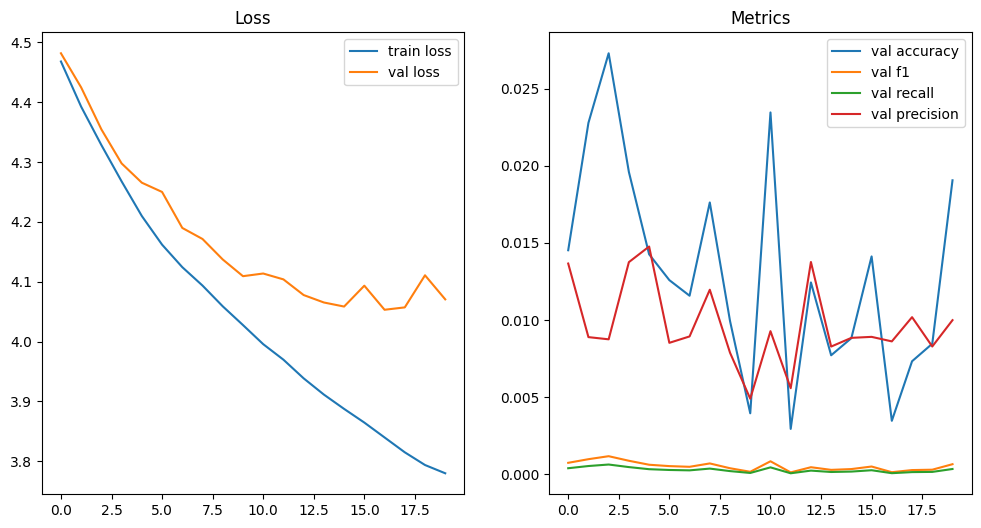

In [10]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'], label='val accuracy')
    plt.plot(history['val_f1'], label='val f1')
    plt.plot(history['val_recall'], label='val recall')
    plt.plot(history['val_precision'], label='val precision')
    plt.legend()
    plt.title('Metrics')

    plt.show()

plot_history(encoder_history)

### Classifier training

In [11]:
for param in encoder.parameters():
    param.requires_grad = False

# Train the classifier
print("Training classifier...")
classifier_history = train_classifier(encoder, classifier, train_loader, val_loader, optimizer_cls, criterion_cls, classifier_epochs, device, ckpts_path)
print("Finished training classifier")

Training classifier...


100%|██████████| 20/20 [11:29<00:00, 34.48s/it]

Finished training classifier


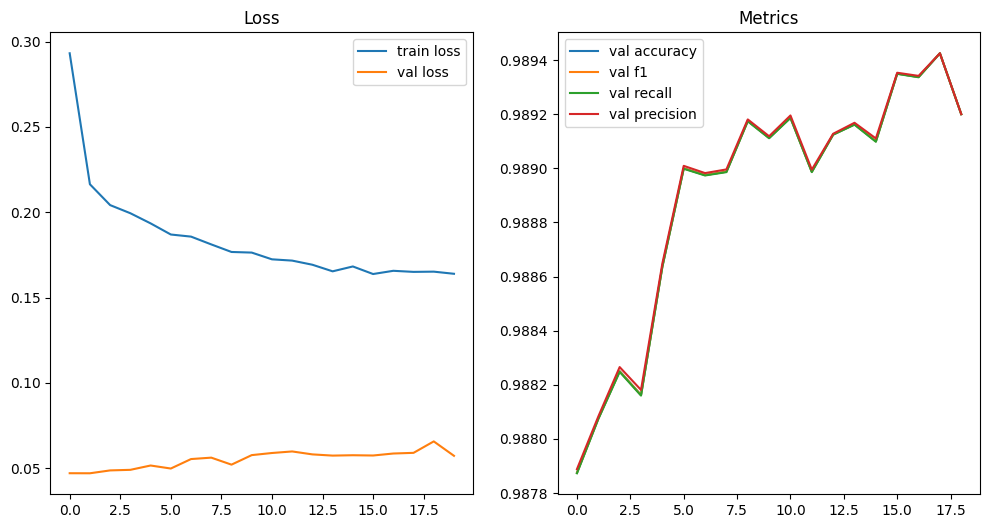

In [12]:
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='train loss')
    plt.plot(history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history['val_acc'][:-1], label='val accuracy')
    plt.plot(history['val_f1'][:-1], label='val f1')
    plt.plot(history['val_recall'][:-1], label='val recall')
    plt.plot(history['val_precision'][:-1], label='val precision')
    plt.legend()
    plt.title('Metrics')

    plt.show()

plot_history(classifier_history)

## Evaluation

In [13]:
images = test_images
labels = test_labels
test_dataset = ImageDataset(images, labels, transform=transform)
test_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [14]:
next(iter(test_loader))[0].shape

torch.Size([128, 3, 32, 32])

In [15]:


def test(encoder, classifier, dataloader, device):
    encoder.eval()
    classifier.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    print(classification_report(all_labels, all_predictions, digits=4))

    return all_labels, all_predictions

# Test the model
test_labels, test_predictions = test(encoder, classifier, test_loader, device)

c:\Users\CL-11\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


              precision    recall  f1-score   support

           0     0.9913    0.9874    0.9893     39965
           1     0.9874    0.9914    0.9894     40035

    accuracy                         0.9894     80000
   macro avg     0.9894    0.9894    0.9894     80000
weighted avg     0.9894    0.9894    0.9894     80000



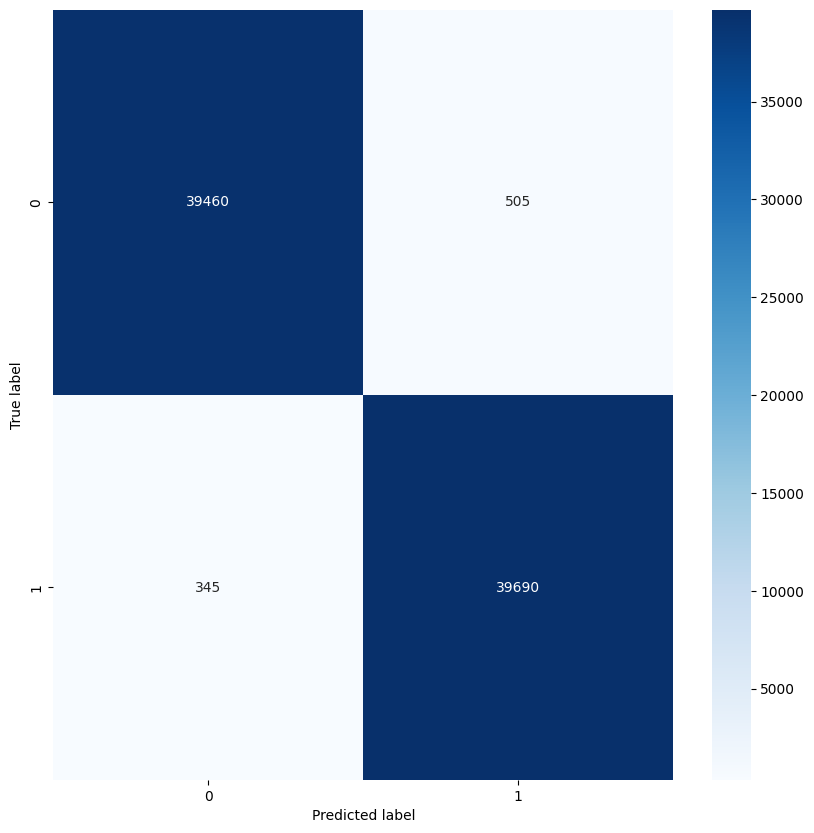

In [16]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

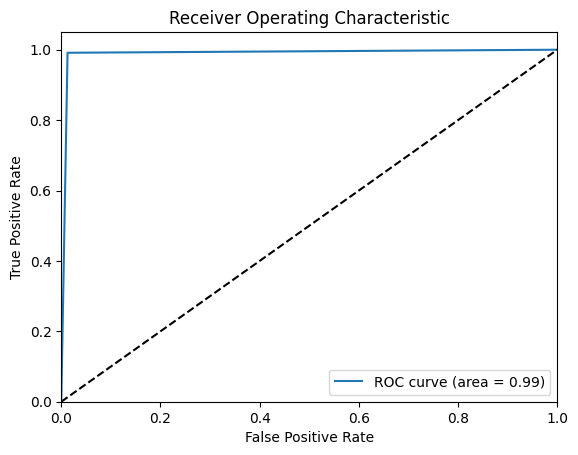

In [17]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(test_labels, test_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

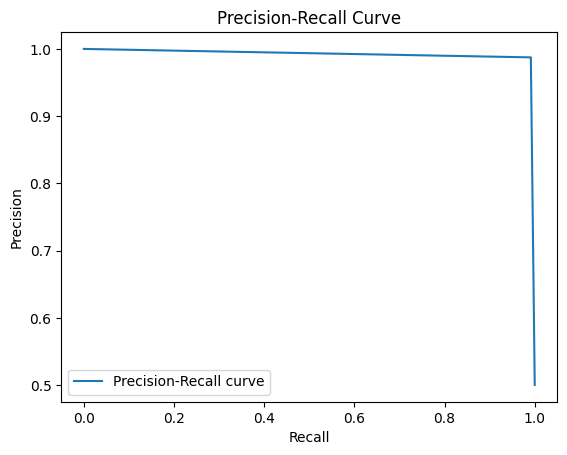

In [18]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_predictions)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()